# Braintriage challenge example

# Import packages
Here we import important packages. Add any packages you need.

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import os
import SimpleITK as sitk
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math as math
import csv

from tqdm.notebook import tqdm
import pdb

# Create dataset
We only have to extract the slices once so I decide to extract all slices. The resolution is 512x512x32 so we can assume each patient has 32 slices.

In [ ]:
in_dir = '../../data/full'
out_dir = '../../data_sliced'


if not os.path.exists(out_dir):
    os.makedirs(out_dir)
            
for klass in os.listdir(in_dir):

    for patient in os.listdir(os.path.join(in_dir, klass)):

        ## Check if patient has not been processed yet
        out_path = os.path.join(out_dir, patient+'.pt')
        if not os.path.exists(out_path):

            ## Paths to the image files
            t1_path = os.path.join(in_dir,klass,patient,'T1.mha')
            t2_path = os.path.join(in_dir,klass,patient,'T2.mha')
            t2_flair_path = os.path.join(in_dir,klass,patient,'T2-FLAIR.mha')

            ## Load all images
            t1_image = sitk.ReadImage(t1_path)
            t2_image = sitk.ReadImage(t2_path)
            t2_flair_image = sitk.ReadImage(t2_flair_path)

            ## Check if the number of slices is equal in all series
            if t1_image.GetSize()[-1] == t2_image.GetSize()[-1] == t2_flair_image.GetSize()[-1]:
                
                with open(out_dir+'/labels_slices_z.csv', 'a') as csvfile:
                    w = csv.writer(csvfile, delimiter=',')

                    if klass == 'normal':
                        w.writerow([patient, 0])
                    elif klass == 'abnormal':
                        w.writerow([patient, 1])
                
                ## Instead of the center slice of an image we would like to have all slices
                ## We can decide later which slices to actually use for training...
                
                ## better to have lots of small files than one big file ?
                
                nr_of_slices = t1_image.GetSize()[-1]
                for slice_number in range(nr_of_slices):
                
                    ## Convert the images to numpy arrays
                    t1_array = sitk.GetArrayFromImage(t1_image)
                    t2_array = sitk.GetArrayFromImage(t2_image)
                    t2_flair_array = sitk.GetArrayFromImage(t2_flair_image)

                    ## Extract the center slices from the images
                    t1_slice = t1_array[slice_number,:,:]
                    t2_slice = t2_array[slice_number,:,:]
                    t2_flair_slice = t2_flair_array[slice_number,:,:]

                    ## Create one data array
                    comb_data = np.zeros((3,512,512))
                    comb_data[0,:,:] = t1_slice
                    comb_data[1,:,:] = t2_slice
                    comb_data[2,:,:] = t2_flair_slice
                    ## Save as torch tensor for quick loading during training
                    torch.save(torch.from_numpy(comb_data.astype('float32')),out_dir+'/' +patient+ '_' + str(slice_number) +'.pt')

                    ## TODO use tqdm 
                    print("Slice  {} saved for: {} ".format(slice_number,patient))

                    del t1_array, t2_array, t2_flair_array

            else:
                print("Number of slices not equal for:", patient)
                del t1_image, t2_image, t2_flair_image
        else:
            continue

We create a dataset class that is compatible with the 'data_loader' from PyTorch. This allows us to feed our images to the network efficiently during training and validation. We read the labels for the different patients from a CSV file and convert this into a dictionary. Based on these labels we split the data in a training and validation set (you can choose a different ratio).

In [5]:
### Define custom dataset class ###


## The resolution is 512x512x32 so we can assume each patient has 32 slices  

class Dataset(data.Dataset):
  #'Characterizes a dataset for PyTorch'
    def __init__(self, list_IDs, labels, location):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs
        self.loc = location

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        X = torch.load(self.loc + '/' + ID + '.pt')#/2749
        y = torch.FloatTensor([self.labels[ID]])

        return X, y

### Specify data directory ###    
data_dir =  '../../data_test'

### Load labels and convert to dict ###
labelsn = {}
labelsa = {}

n=0
a=0

with open(data_dir+'/labels_slices_z.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for rows in reader:
        if float(rows[1])==0 and n<500:
            n = n+1
            labelsn[rows[0]] = float(rows[1])
        elif float(rows[1])==1 and a<500:
            a = a+1
            labelsa[rows[0]] = float(rows[1])
labels = {**labelsn,**labelsa}
            
### Based on the labels, split data in training and validation set ###
IDn = np.asarray(list(labelsn.keys()))
IDa = np.asarray(list(labelsa.keys()))
n_samples = IDa.shape[0]

IDn = IDn[np.random.permutation(n_samples)]
IDa = IDa[np.random.permutation(n_samples)]

data_sets = {}
data_sets['train'] = np.concatenate((IDn[:int(0.8*n_samples)],IDa[:int(0.8*n_samples)]))
data_sets['validation'] = np.concatenate((IDn[int(0.8*n_samples):],IDa[int(0.8*n_samples):]))

training_set = Dataset(data_sets['train'], labels, data_dir)
validation_set = Dataset(data_sets['validation'], labels, data_dir)


You can visually inspect the data by making a plot of a scan.

In [33]:
import matplotlib
import matplotlib.pyplot as plt

X = torch.load(data_dir + '/' + '16' + '.pt')#/2749

plt.figure()
plt.imshow(X.data.numpy()[2,:,:])

## Some visual inspection of the slides

In [189]:
def plot_slices(patient,range_of_slices):

    if type(range_of_slices) == tuple:
        assert range_of_slices[0] < range_of_slices[1]
        size_of_range = range_of_slices[1] - range_of_slices[0]
        nr_of_rows = size_of_range // 4 + 1
        nr_of_cols = 4 # max 4 plots per row 

        subplots_to_delete = (4 - size_of_range%4) - 1 ## subplots of last row that will turn out empty..
        
        fig,axs = plt.subplots(nr_of_rows,nr_of_cols, figsize=(12,12))
        fig.tight_layout(pad=.5)
        for index,slice_number in enumerate(range(range_of_slices[0],range_of_slices[1]+1)): #inclusive..
            X = torch.load(data_dir + '/' + str(patient) + '_' + str(slice_number) + '.pt')
            if nr_of_rows > 1:
                axes = axs[ index//4 , index%4 ]
            else:
                axes = axs[index]
            axes.imshow(X.data.numpy()[2,:,:])
            axes.set_title("Patient {} slice number {}".format(patient,slice_number))
            
        # make sure we don't have these empty white subplots
        for empty_subplot in range(3, 4 - subplots_to_delete - 1, -1):
            fig.delaxes(axs[nr_of_rows-1][empty_subplot])
    else:
        slice_number =range_of_slices
        X=torch.load(data_dir + '/' + str(patient) + '_' + str(slice_number) + '.pt')

        plt.figure()
        plt.imshow(X.data.numpy()[2,:,:]) 
        plt.title("Patient {} slice number {}".format(patient,slice_number))
    plt.show()

    

    

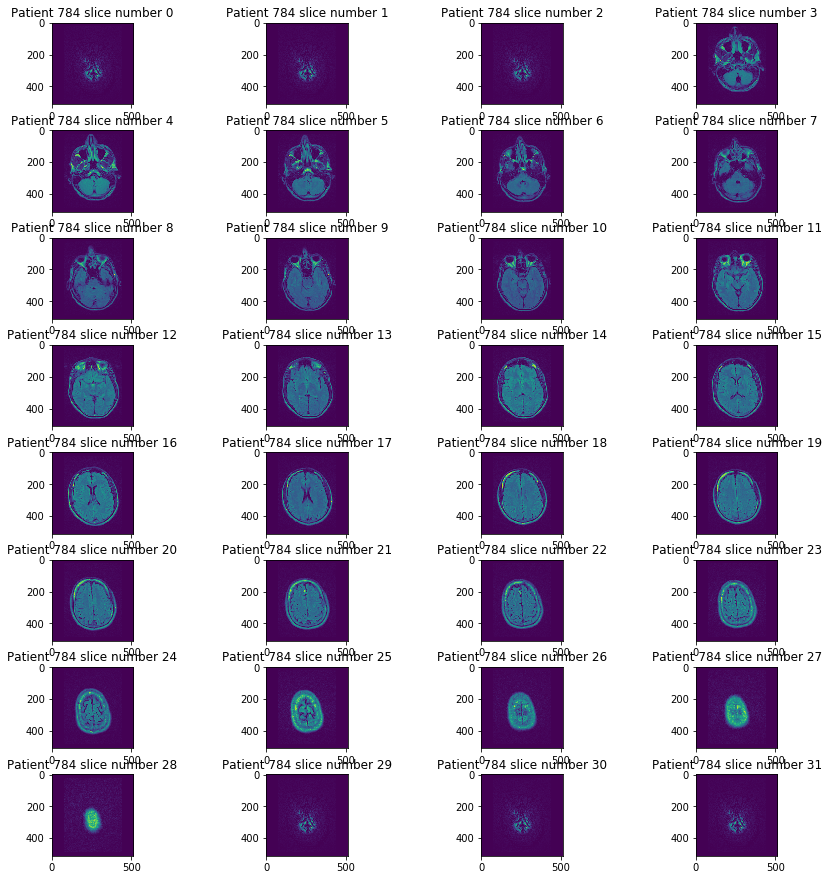

In [190]:
data_dir = '../../data_test'

plot_slices(784,(0,31))

## Fully connected model for Feature extraction


In [7]:
class FeatureVectorModel(nn.Module):
    def __init__(self, n_features):
        super(FeatureVectorModel, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_1 = nn.Linear(512*512*3, 256)
        self.feature_linear = nn.Linear(256, n_features)
        self.classification_linear = nn.Linear(n_features, 1)
        # For saving model and loss values
        self.name = "FCNet" 
        
    def forward(self, x):
        h = self.linear_1(self.flatten(x))
        h = self.feature_linear(h)
        h = self.classification_linear(h)
        # We don't need Softmax when using BCEWithLogitsLoss
        return h
        

## LSTM Model

In [8]:
class LSTM(nn.Module):
    def __init__(self, n_features, n_hidden, n_layers=1):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=n_hidden, 
                            num_layers=n_layers, batch_first=True)
        self.classification_linear = nn.Linear(n_hidden,1)
        # For saving model and loss values
        self.name = "LSTMNet" 
        
    def forward(self, x):
        lstm_output, (_, _) = self.lstm(x)
        output = self.classification_linear(lstm_output[:,-1])
        return output

## Combined model

In [9]:
class CombinedNet(nn.Module):
    def __init__(self, fc_net, lstm_net, do_freeze_fc_net=False):
        super(CombinedNet, self).__init__()
        # Remove classification layer from FC network
        self.fc_net = torch.nn.Sequential(*(list(fc_net.children())[:-1]))
        self.lstm_net = lstm_net
        # For saving model and loss values
        self.name = "CombinedNet" 
    
    def forward(self, x):
        '''
        THIS CODE WILL BE RELEVANT FOR WHEN WE HAVE MULTIPLE SLICES IN THE DATA

        # Loop over all slices and compute feature vectors with FC net
        feature_vectors = []
        for slice_ in x:
            feature_vector = self.fc_net(slice_)
            feature_vectors.append(feature_vector)

        # Convert to Tensor and compute predictions with LSTM net
        feature_tensor = torch.Tensor(feature_vectors)
        prediction = self.lstm_net(feature_tensor)
        '''
        feature_vector = self.fc_net(x)
        feature_vector = torch.unsqueeze(feature_vector, 1)
        prediction = self.lstm_net(feature_vector)
        return prediction

    def set_learning_fc_net(self, do_learning):
        for param in self.fc_net.parameters():
                param.requires_grad = do_learning

# Initialize model
Here we set the different training and model parameters. The model is initialized and a loss function and optimizer are choosen. Finally a training and validation iterator is created.

In [12]:
### Parameters ###
device = 1
epochs = 1
batch_size = 5
n_features=128

model_dir = './models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

### Create model ###
# model = Model(in_channels,outsize) #.cuda() # if device < 0 else Model(1,outsize).to_gpu(device)
model = FeatureVectorModel(n_features=n_features)
### Loss and optimizer ###
criterion = nn.BCEWithLogitsLoss()#nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)

### Create data generator ###

training_iterator = data.DataLoader(training_set, batch_size=batch_size, shuffle = True)
validation_iterator = data.DataLoader(validation_set, batch_size=batch_size, shuffle = False)

# Training and validation
In the next cell the model is trained and validated. The loss is printed and the model is saved after every epoch.

In [13]:
def train(model, loss, optimizer, train_loader, val_loader, batch_size, n_epochs=1):
    print(f'Running {model.name}')

    ### Training and validation ###
    loss_history = {'training': [], 'validation': []}
    acc_history = {'training': [], 'validation': []}

    for j in tqdm(range(n_epochs), desc="#epochs"):
        loss_history['training'].append(0)
        acc_history['training'].append(0)

        for i, (images, targets) in tqdm(enumerate(train_loader), total=len(training_set)//(batch_size+1), desc="#train_batches", leave=False):

            model.train()
            optimizer.zero_grad()

            predictions = model(images)
            loss = criterion(predictions, targets)

            loss.backward()

            optimizer.step()
            
            #Accuracy
            accuracy_predictions = (F.sigmoid(predictions)>0.5).float()

            correct = (accuracy_predictions == targets).float().sum()/accuracy_predictions.shape[0]

            loss_history['training'][-1] += float(loss.data)
            acc_history['training'][-1] += float(correct)

        loss_history['training'][-1] /= i + 1
        acc_history['training'][-1] /= i + 1

        loss_history['validation'].append(0)
        acc_history['validation'].append(0)

        for i, (images, targets) in tqdm(enumerate(val_loader), total=len(validation_set)//(batch_size+1), desc="#test_batches", leave=False):

            model.eval()

            predictions = model(images)
            loss = criterion(predictions, targets)
            
            #Accuracy
            accuracy_predictions = (F.sigmoid(predictions)>0.5).float()
            correct = (accuracy_predictions == targets).float().sum()/accuracy_predictions.shape[0]
        
            loss_history['validation'][-1] += float(loss.data)
            acc_history['validation'][-1] += float(correct)

        loss_history['validation'][-1] /= i + 1
        acc_history['validation'][-1] /= i + 1

        print('epoch: {:3d} / {:03d}, training loss: {:.4f}, validation loss: {:.4f}, training accuracy: {:.3f}, validation accuracy: {:.3f}.'.format(j + 1, epochs, loss_history['training'][-1], loss_history['validation'][-1], acc_history['training'][-1], acc_history['validation'][-1]))
        np.savez('{:s}/{:s}_loss_history_{:03d}.npz'.format(model_dir, model.name, j), loss_history)
        torch.save(model.state_dict(), '{:s}/{:s}_{:03d}.npz'.format(model_dir, model.name, j))

## FC NET

In [14]:
### Parameters ###
epochs = 1
batch_size = 32
n_features = 128

model_dir = './models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

### Create model ###
fc_net = FeatureVectorModel(n_features=n_features)

### Loss and optimizer ###
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(fc_net.parameters(), lr=0.0001)

### Create data generator (redefine for each network) ###
training_iterator = data.DataLoader(training_set, batch_size=batch_size, shuffle = True)
validation_iterator = data.DataLoader(validation_set, batch_size=batch_size, shuffle = False)

In [17]:
train(model=fc_net, loss=criterion, optimizer=optimizer, 
      train_loader=training_iterator, val_loader=validation_iterator, 
      batch_size=batch_size, n_epochs=epochs)

Running FCNet


/home/chb3k/anaconda3/envs/py37ismi/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch:   1 / 001, training loss: 4181.0847, validation loss: 509.3031, training accuracy: 0.490, validation accuracy: 0.585.



## LSTM

In [18]:
### Parameters ###
epochs = 1
batch_size = 32
n_features = 128
n_hidden = 64

model_dir = './models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

### Create model ###
lstm_net = LSTM(n_features=n_features, n_hidden=n_hidden, n_layers=1)
combined_net = CombinedNet(fc_net=fc_net, lstm_net=lstm_net)
# Turn off learning for FC_net
combined_net.set_learning_fc_net(False)

### Loss and optimizer ###
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(combined_net.parameters(), lr=0.0001)

### Create data generator (redefine for each network) ###
training_iterator = data.DataLoader(training_set, batch_size=batch_size, shuffle = True)
validation_iterator = data.DataLoader(validation_set, batch_size=batch_size, shuffle = False)

In [19]:
train(model=combined_net, loss=criterion, optimizer=optimizer, 
      train_loader=training_iterator, val_loader=validation_iterator, 
      batch_size=batch_size, n_epochs=epochs)

Running CombinedNet


epoch:   1 / 001, training loss: 0.6727, validation loss: 0.6768, training accuracy: 0.583, validation accuracy: 0.576.



## CombinedNet

In [20]:
### Parameters ###
epochs = 1
batch_size = 32

# Turn learning for fc_net back on
combined_net.set_learning_fc_net(True)

### Loss and optimizer ###
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(combined_net.parameters(), lr=0.000001)

### Create data generator (redefine for each network) ###
training_iterator = data.DataLoader(training_set, batch_size=batch_size, shuffle = True)
validation_iterator = data.DataLoader(validation_set, batch_size=batch_size, shuffle = False)

In [21]:
train(model=combined_net, loss=criterion, optimizer=optimizer, 
      train_loader=training_iterator, val_loader=validation_iterator, 
      batch_size=batch_size, n_epochs=epochs)

Running CombinedNet


epoch:   1 / 001, training loss: 0.6708, validation loss: 0.6766, training accuracy: 0.573, validation accuracy: 0.603.



# Testing
Here we show some example code that you can use to run your model on the test data set once this is provided and create a .csv submission file that you can upload to grand challenge.

# Select slices for test set
Here we do the same as above to select slices from the test set.

In [ ]:
in_dir = 'path/to/test_in_dir'
out_dir = 'path/to/test_out_dir'


if not os.path.exists(out_dir):
    os.makedirs(out_dir)
            
for klass in os.listdir(in_dir):

    for patient in os.listdir(os.path.join(in_dir, klass)):

        ## Check if patient has not been processed yet
        out_path = os.path.join(out_dir, patient+'.pt')
        if not os.path.exists(out_path):

            ## Paths to the image files
            t1_path = os.path.join(in_dir,klass,patient,'T1.mha')
            t2_path = os.path.join(in_dir,klass,patient,'T2.mha')
            t2_flair_path = os.path.join(in_dir,klass,patient,'T2-FLAIR.mha')

            ## Load all images
            t1_image = sitk.ReadImage(t1_path)
            t2_image = sitk.ReadImage(t2_path)
            t2_flair_image = sitk.ReadImage(t2_flair_path)

            ## Check if the number of slices is equal in all series
            if t1_image.GetSize()[-1] == t2_image.GetSize()[-1] == t2_flair_image.GetSize()[-1]:
                
                with open(out_dir+'/labels_slices_z_test.csv', 'a') as csvfile:
                    w = csv.writer(csvfile, delimiter=',')

                    if klass == 'normal':
                        w.writerow([patient, 0])
                    elif klass == 'abnormal':
                        w.writerow([patient, 1])
                
                ## Determine center slice of images
                z = int(t1_image.GetSize()[-1]/2)

                ## Convert the images to numpy arrays
                t1_array = sitk.GetArrayFromImage(t1_image)
                t2_array = sitk.GetArrayFromImage(t2_image)
                t2_flair_array = sitk.GetArrayFromImage(t2_flair_image)

                ## Extract the center slices from the images
                t1_slice = t1_array[z,:,:]
                t2_slice = t2_array[z,:,:]
                t2_flair_slice = t2_flair_array[z,:,:]

                ## Create one data array
                comb_data = np.zeros((3,512,512))
                comb_data[0,:,:] = t1_slice
                comb_data[1,:,:] = t2_slice
                comb_data[2,:,:] = t2_flair_slice
                
                ## Save as torch tensor for quick loading during training
                torch.save(torch.from_numpy(comb_data.astype('float32')),out_dir+'/'+patient+'.pt')

                
                print("Slices saved for:", patient)

                del t1_array, t2_array, t2_flair_array

            else:
                print("Number of slices not equal for:", patient)
                del t1_image, t2_image, t2_flair_image
        else:
            continue

We create a test dataset from these slices.

In [5]:
### Specify test data directory ###    
test_dir = '/path/to/test_out_dir'

### Load labels and convert to dict ###
labels_test = {}

with open(test_dir+'/labels_slices_z_test.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for rows in reader:
        labels_test[rows[0]] = float(rows[1])
           
data_sets['test'] = np.asarray(list(labels_test.keys()))

test_set = Dataset(data_sets['test'], labels_test, test_dir)


# Run trained model on the test set.
Run the model with the best validation loss on the test set to obtain a 'submission' csv file. You can upload this file to grand challenge to see how well you perform and add your score to the leaderboard.

In [11]:
test_iterator = data.DataLoader(test_set, batch_size=1, shuffle = False)

j = 4
model = Model(in_channels,outsize).cuda() # if device < 0 else Model(1,outsize).to_gpu(device)
checkpoint = torch.load('{:s}/model_{:03d}.npz'.format(model_dir, j))

model.load_state_dict(checkpoint)
model.eval()
m =nn.Sigmoid()

with open(test_dir+'/submission.csv', 'a') as csvfile:
    w = csv.writer(csvfile, delimiter=',')
    w.writerow(['case','probability','class'])
    for i, batch in enumerate(test_iterator):
        images, targets = batch[0].cuda() , batch[1].cuda()
        y = model(images)
        prob = m(y)
        output = prob>0.5
        patient = data_sets['test'][i]
        w.writerow([patient, float(prob), int(output)])